Custom Vision : Azure에는 Cognitive Service라고 하는 사전 학습된 AI 모델들이 있다. 
이 중, Custom Vision은 이미지에서 특정 개체를 감지하거나 이미지를 분류하는 사전 학습 모델임.



In [2]:
#%pip install azure-cognitiveservices-vision-customvision

기존 프로젝트가 존재하여, 해당 프로젝트를 사용
기존 포크 Tag 가져오기
기존 가위 Tag 가져오기
이미 배포된 모델입니다! : Iteration is already published as: kitchen-v1
포크 : 76.02%
포크 : 73.23%


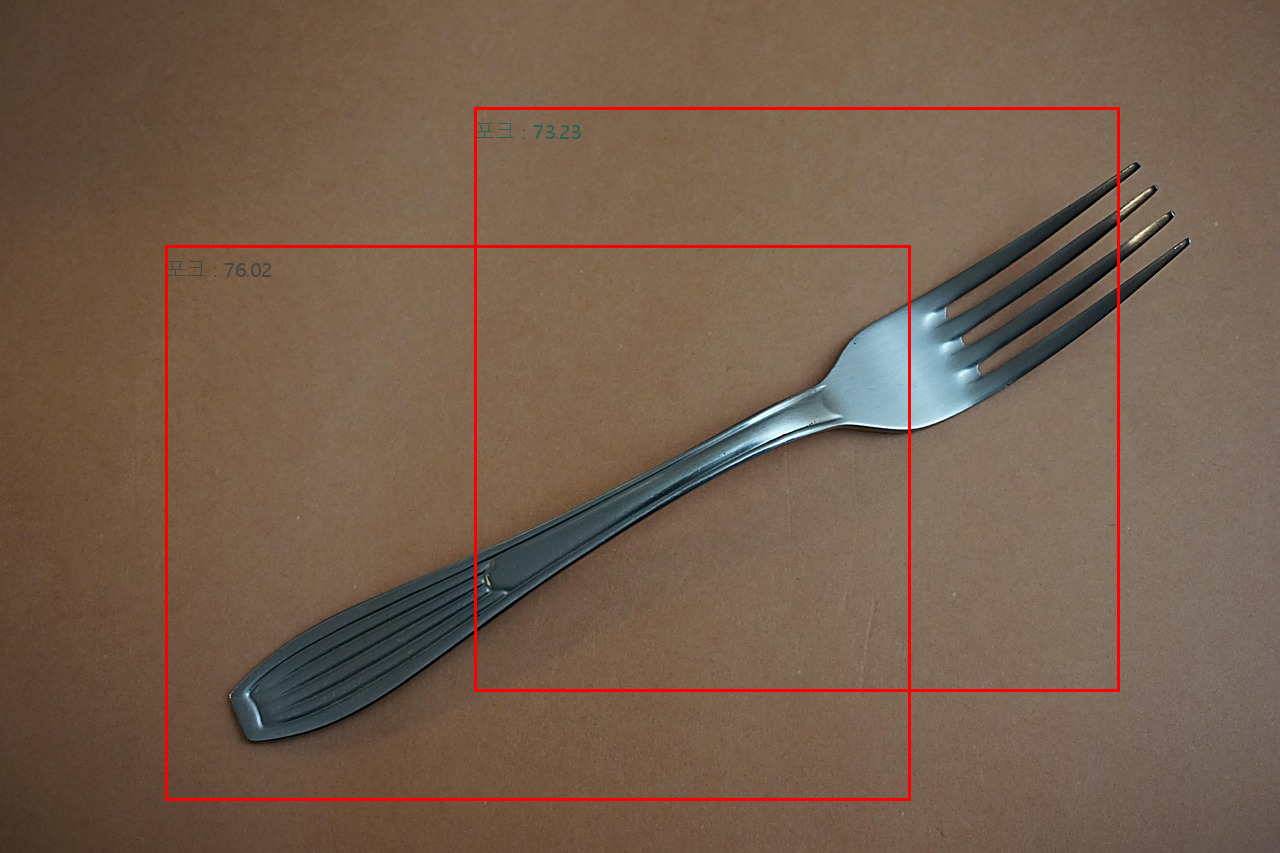

In [ ]:
# 모델 학습과 관련된 모든 작업(프로젝트 생성/삭제, 태그 관리, 이미지 업로드, 학습 반복(Iteration) 실행 및 관리 등)
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient 
# 학습된 모델을 사용하여 이미지에 대한 예측을 수행
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient 
# 커스텀 비전이 요구하는 데이터 구조를 정의(ImageFileCreateBatch : 여러 이미지를 한 번에 업로드하기 위한 배치 컨테이너, ImageFileCreateEntry : 개별 이미지 파일의 정보, Region: 객체 탐지를 위해 이미지 내의 바운딩 박스를 정의할 때 사용)
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region 
# Azure 서비스에 접근하기 위해 필요한 API 키를 사용하여 인증 자격 증명 생성
from msrest.authentication import ApiKeyCredentials 
import os, time, uuid
from dotenv import load_dotenv
load_dotenv()

#==========================================================================================================================
# 1. 기본 정보 설정
#==========================================================================================================================

# (학습용) 8ai022-customvision 리소스의 엔드포인트 및 API 키
TRAINING_ENDPOINT = "https://8ai022customvision.cognitiveservices.azure.com/"
TRAINING_API_KEY = os.getenv("TRAINING_API_KEY")

# (테스트용) 8ai022customvision-Prediction 리소스의 엔드포인트 및 API 키
PREDICTION_ENDPOINT = "https://8ai022customvision-prediction.cognitiveservices.azure.com/"
PREDICTION_API_KEY = os.getenv("PREDICTION_API_KEY")

# 8ai022customvision-Prediction 리소스의 - 리소스 관리 Tab - 속성 Tab - 리소스 ID
PREDICTION_RESOUCE_ID = os.getenv("PREDICTION_RESOUCE_ID")

#==========================================================================================================================
# 2. Trainer, Predictor 클라이언트 객체 생성
#==========================================================================================================================

# 자격 증명 객체 생성
training_credentials = ApiKeyCredentials(in_headers={"Training-key" : TRAINING_API_KEY})
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key" : PREDICTION_API_KEY})

# 자격 증명으로 인증하여 Trainer, Predictor 클라이언트 객체 생성
trainer = CustomVisionTrainingClient(endpoint=TRAINING_ENDPOINT, credentials=training_credentials)
predictor = CustomVisionPredictionClient(endpoint=PREDICTION_ENDPOINT, credentials=prediction_credentials)

# 기존 프로젝트 및 도메인 목록 출력 디버깅 코드
"""
project_list = trainer.get_projects()
for project in project_list : 
    print("프로젝트 이름 : ", project.name, ", 프로젝트 ID : ", project.id)

domain_list = trainer.get_domains() # 커스텀 비전이 지원하는 모델들
for domain in domain_list :
    print("도메인 이름 : ", domain.name, ", 도메인 ID : ", domain.id)
"""

#==========================================================================================================================
# 3. 프로젝트 생성 
#==========================================================================================================================
project_name = "8ai022-kitchen"
project_description = "포크와 가위를 감지하는 모델"
project_id = ""
domain_id = ""

# 기존 프로젝트 존재 여부 검증
project_list = trainer.get_projects()
for project in project_list : 
    if project.name == project_name : 
        print("기존 프로젝트가 존재하여, 해당 프로젝트를 사용")
        project_id = project.id
        break

# 객체 검출(ObjectDetection) 모델 중에서 General (compact) 도메인 선택#
domain_list = trainer.get_domains() # 커스텀 비전이 지원하는 모델들
for domain in domain_list : 
    if domain.type == "ObjectDetection" and domain.name == "General (compact)" :
        domain_id = domain.id
        break

if project_id == "" :
    print("기존 프로젝트가 존재하지 않아, 새로운 프로젝트를 생성")
    project = trainer.create_project(name=project_name, description=project_description, domain_id=domain_id)

#==========================================================================================================================
# 4. 태그 생성 (name은 중복 불가. 동일한 이름의 태그가 존재하면 에러 발생)
#==========================================================================================================================    
FORK_TAG_NAME = "포크"
SCISSOR_TAG_NAME = "가위"

fork_tag = None
scissor_tag = None

# 기존 태그 존재하면 가져오기
for tag in trainer.get_tags(project.id) :
    if tag.name == FORK_TAG_NAME : 
        print('기존 포크 Tag 가져오기')
        fork_tag = tag
    elif tag.name == SCISSOR_TAG_NAME : 
        print('기존 가위 Tag 가져오기')
        scissor_tag = tag

# 기존 태그 없는 경우, 태그 생성
if fork_tag is None : 
    print('포크 Tag 생성')
    fork_tag = trainer.create_tag(project.id, FORK_TAG_NAME)
if scissor_tag is None : 
    print('가위 Tag 생성')
    scissor_tag = trainer.create_tag(project.id, SCISSOR_TAG_NAME)

#==========================================================================================================================
# 5. 이미지별 바운딩 박스 좌표 정의
#==========================================================================================================================    

# 이미지 내의 포크와 가위가 위치한 영역(바운딩 박스)의 정규화된 좌표들. [x, y, width, height]
# 예시) x는 이미지 왼쪽에서 14.58% 지점, y는 이미지 위에서 35.09% 지점, width는 이미지 가로 길이의 58.95%, height는 이미지 세로 길이의 23.85%
# 이미지의 좌표값을 얻는 방법 ==> 10-Vision-251208.ipynb에서 했던 Object Detection 참고
fork_image_regions = {
    "fork_1": [ 0.145833328, 0.3509314, 0.5894608, 0.238562092 ], 
    "fork_2": [ 0.294117659, 0.216944471, 0.534313738, 0.5980392 ],
    "fork_3": [ 0.09191177, 0.0682516545, 0.757352948, 0.6143791 ],
    "fork_4": [ 0.254901975, 0.185898721, 0.5232843, 0.594771266 ],
    "fork_5": [ 0.2365196, 0.128709182, 0.5845588, 0.71405226 ],
    "fork_6": [ 0.115196079, 0.133611143, 0.676470637, 0.6993464 ],
    "fork_7": [ 0.164215669, 0.31008172, 0.767156839, 0.410130739 ],
    "fork_8": [ 0.118872553, 0.318251669, 0.817401946, 0.225490168 ],
    "fork_9": [ 0.18259804, 0.2136765, 0.6335784, 0.643790841 ],
    "fork_10": [ 0.05269608, 0.282303959, 0.8088235, 0.452614367 ],
    "fork_11": [ 0.05759804, 0.0894935, 0.9007353, 0.3251634 ],
    "fork_12": [ 0.3345588, 0.07315363, 0.375, 0.9150327 ],
    "fork_13": [ 0.269607842, 0.194068655, 0.4093137, 0.6732026 ],
    "fork_14": [ 0.143382356, 0.218578458, 0.7977941, 0.295751631 ],
    "fork_15": [ 0.19240196, 0.0633497, 0.5710784, 0.8398692 ],
    "fork_16": [ 0.140931368, 0.480016381, 0.6838235, 0.240196079 ],
    "fork_17": [ 0.305147052, 0.2512582, 0.4791667, 0.5408496 ],
    "fork_18": [ 0.234068632, 0.445702642, 0.6127451, 0.344771236 ],
    "fork_19": [ 0.219362751, 0.141781077, 0.5919118, 0.6683006 ],
    "fork_20": [ 0.180147052, 0.239820287, 0.6887255, 0.235294119 ]
}
scissors_image_regions = {
    "scissors_1": [ 0.4007353, 0.194068655, 0.259803921, 0.6617647 ],
    "scissors_2": [ 0.426470578, 0.185898721, 0.172794119, 0.5539216 ],
    "scissors_3": [ 0.289215684, 0.259428144, 0.403186262, 0.421568632 ],
    "scissors_4": [ 0.343137264, 0.105833367, 0.332107842, 0.8055556 ],
    "scissors_5": [ 0.3125, 0.09766343, 0.435049027, 0.71405226 ],
    "scissors_6": [ 0.379901975, 0.24308826, 0.32107842, 0.5718954 ],
    "scissors_7": [ 0.341911763, 0.20714055, 0.3137255, 0.6356209 ],
    "scissors_8": [ 0.231617644, 0.08459154, 0.504901946, 0.8480392 ],
    "scissors_9": [ 0.170343131, 0.332957536, 0.767156839, 0.403594762 ],
    "scissors_10": [ 0.204656869, 0.120539248, 0.5245098, 0.743464053 ],
    "scissors_11": [ 0.05514706, 0.159754932, 0.799019635, 0.730392158 ],
    "scissors_12": [ 0.265931368, 0.169558853, 0.5061275, 0.606209159 ],
    "scissors_13": [ 0.241421565, 0.184264734, 0.448529422, 0.6830065 ],
    "scissors_14": [ 0.05759804, 0.05027781, 0.75, 0.882352948 ],
    "scissors_15": [ 0.191176474, 0.169558853, 0.6936275, 0.6748366 ],
    "scissors_16": [ 0.1004902, 0.279036, 0.6911765, 0.477124184 ],
    "scissors_17": [ 0.2720588, 0.131977156, 0.4987745, 0.6911765 ],
    "scissors_18": [ 0.180147052, 0.112369314, 0.6262255, 0.6666667 ],
    "scissors_19": [ 0.333333343, 0.0274019931, 0.443627447, 0.852941155 ],
    "scissors_20": [ 0.158088237, 0.04047389, 0.6691176, 0.843137264 ]
}

# 이미지 존재 여부 확인
for key in fork_image_regions.keys() :
    with open(f"files/fork/{key}.jpg", "rb") as image_file : 
        pass
for key in scissors_image_regions.keys() :
    with open(f"files/scissors/{key}.jpg", "rb") as image_file : 
        pass


#==========================================================================================================================
# 6. 이미지 업로드
#==========================================================================================================================        
image_list = []

# 포크 이미지 처리
for file_name, bounding_box in fork_image_regions.items() : 
    with open(f"files/fork/{file_name}.jpg", "rb") as image_file : 
        # 바운딩 박스 객체 생성
        region = Region(tag_id=fork_tag.id, left=bounding_box[0], top=bounding_box[1], width=bounding_box[2], height=bounding_box[3])

        # 이미지와 바운딩 박스를 연결
        # regions : 하나의 이미지에 바운딩 박스가 여러개일 수 있으므로 리스트로 전달
        image_data = image_file.read()
        image_list.append(ImageFileCreateEntry(name=file_name+".jpg", contents=image_data, regions=[region]))

# 가위 이미지 처리
for file_name, bounding_box in scissors_image_regions.items() : 
    with open(f"files/scissors/{file_name}.jpg", "rb") as image_file : 
        # 바운딩 박스 객체 생성
        region = Region(tag_id=scissor_tag.id, left=bounding_box[0], top=bounding_box[1], width=bounding_box[2], height=bounding_box[3])

        # 이미지와 바운딩 박스를 연결
        # regions : 하나의 이미지에 바운딩 박스가 여러개일 수 있으므로 리스트로 전달
        image_data = image_file.read()
        image_list.append(ImageFileCreateEntry(name=file_name+".jpg", contents=image_data, regions=[region]))


# CustomVision에 이미지 업로드
upload_result = trainer.create_images_from_files(project_id=project.id, batch=ImageFileCreateBatch(images=image_list))
#upload_result.images[n].source_url => 파일명
#upload_result.images[n].status     => 업로드 상태

#==========================================================================================================================
# 7. 업로드한 이미지로 모델 학습
#==========================================================================================================================        
import time
iteration_list = trainer.get_iterations(project.id)

iteration = None

if len(iteration_list) > 0 : 
    iteration = iteration_list[0]
else : 
    iteration = trainer.train_project(project_id=project.id)

while iteration.status == "Training" : 
    print(f"{iteration.name} : {iteration.status}")
    iteration = trainer.get_iteration(project_id=project.id, iteration_id=iteration.id)
    time.sleep(5)


#==========================================================================================================================
# 8. 모델 배포
#==========================================================================================================================        
publish_name = "kitchen-v1"

try : 
    trainer.publish_iteration(project.id, iteration.id, publish_name, PREDICTION_RESOUCE_ID)
    print(f"{publish_name} 모델 배포 완료!")
except Exception as e :
    print(f"이미 배포된 모델입니다! : {e}")

#==========================================================================================================================
# 9. 예측
#==========================================================================================================================        
import platform
import random
def random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 
def get_font():
    font_size = 20
    
    try:
        if platform.system() == "Windows":
            # 윈도우: 맑은 고딕
            return ImageFont.truetype("malgun.ttf", font_size)
        elif platform.system() == "Darwin":  # macOS
            # 맥: 애플 고딕
            return ImageFont.truetype("AppleGothic.ttf", font_size)
        else:  # Linux 등
            # 기본 폰트 (한글 지원 안 될 수 있음)
            return ImageFont.load_default(size=font_size)
    except IOError:
        # 지정한 폰트 파일이 없을 경우 PIL 기본 폰트 사용
        return ImageFont.load_default()
    
# 9.1 이미지 전달하여 예측
import requests
image_response = requests.get("https://cdn.pixabay.com/photo/2017/08/06/04/48/fork-2588851_1280.jpg")
response = predictor.detect_image(project.id, publish_name, image_response.content)

# 9.1.1 추가) 이미지 표시 및 예측 결과 시각화
from io import BytesIO
from  PIL import Image, ImageDraw, ImageFont
image = Image.open(BytesIO(image_response.content))
draw = ImageDraw.Draw(image)

image_width = image.width
image_height = image.height
font = get_font()

# 9.2 URL로 (detect_image_url_with_no_store 메서드는 예측 이미지를 CustomVision 서버에 저장하지 않음)
#response = predictor.detect_image_url(project.id, publish_name, "https://cdn.pixabay.com/photo/2017/08/06/04/48/fork-2588851_1280.jpg")

for prediction in response.predictions : 
    # 정확도 50% 이상인 결과만 출력
    if prediction.probability > 0.5 : 
        tag_name = prediction.tag_name              # 태그 이름 
        probability = prediction.probability        # 예측 확률(정확도)
        print(f"{tag_name} : {(probability*100):.2f}%")

        # 9.1인 경우, 이미지에 바운딩 박스를 그리기 위한 작업
        bounding_box = prediction.bounding_box # 좌표에 대한 퍼센트 정보
        x = bounding_box.left * image_width     # 좌측에서 x 퍼센트 지점 * 이미지 가로 길이
        y = bounding_box.top * image_height     # 위쪽에서 y 퍼센트 지점 * 이미지 세로 길이
        w = bounding_box.width * image_width    # 바운딩 박스의 가로 길이 = width 퍼센트 * 이미지 가로 길이
        h = bounding_box.height * image_height  # 바운딩 박스의 세로 길이 = height 퍼센트 * 이미지 세로 길이

        draw.rectangle([(x, y), (x + w, y + h)], outline="red", width=3)
        draw.text((x, y+10), f"{tag_name} : {(probability*100):.2f}%", fill=random_color(), font=font)

image